# 🔄 Target Transformations Comparison

**Obiettivo**: Confrontare TUTTE le trasformazioni possibili del target per scegliere la migliore.

**Trasformazioni analizzate**:
1. None (originale)
2. Log (log(x + offset))
3. Log10 (log10(x + offset))
4. Sqrt (√x)
5. Box-Cox (parametrico, solo x > 0)
6. Yeo-Johnson (parametrico, anche x ≤ 0) ← **Attualmente usato nel progetto**
7. Quantile Transformer (uniform/normal)
8. PowerTransformer (Yeo-Johnson sklearn)

**Metriche di valutazione**:
- Skewness (target: ~0)
- Kurtosis (target: ~0 per normale)
- Shapiro-Wilk test (normalità)
- Anderson-Darling test
- Jarque-Bera test
- Q-Q plot visual

**Output**: `transformations_outputs/`

## 🔧 Setup

In [1]:
# Imports
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent / "src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, RobustScaler
import warnings

# Project imports
from utils.config import load_config
from preprocessing.pipeline import apply_data_filters
from preprocessing.target_transforms import (
    apply_target_transform,
    boxcox_transform,
    yeojohnson_transform
)

warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Setup completato")

✅ Setup completato


In [2]:
# Configurazione
CONFIG_PATH = "../config/config.yaml"
RAW_DATA_PATH = "../data/raw/raw.parquet"
OUTPUT_DIR = Path("transformations_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

def save_plot(name, dpi=120):
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"{name}.png", dpi=dpi, bbox_inches='tight')
    print(f"💾 Salvato: {name}.png")

print(f"📂 Output directory: {OUTPUT_DIR}")

📂 Output directory: transformations_outputs


## 📦 1. Load Data

In [3]:
# Load config e data
config = load_config(CONFIG_PATH)
df_raw = pd.read_parquet(RAW_DATA_PATH)

# Applica filtri (come fa il progetto)
df = apply_data_filters(df_raw, config)

# Target
target_col = 'AI_Prezzo_Ridistribuito'
y = df[target_col].dropna().values

print(f"✅ Dataset caricato e filtrato")
print(f"   Campioni: {len(y):,}")
print(f"   Range: €{y.min():,.0f} - €{y.max():,.0f}")
print(f"   Mean: €{y.mean():,.0f}")
print(f"   Median: €{np.median(y):,.0f}")

✅ Dataset caricato e filtrato
   Campioni: 5,499
   Range: €179 - €1,483,526
   Mean: €61,662
   Median: €41,755


## 🔄 2. Apply All Transformations

In [4]:
# Dictionary per raccogliere tutte le trasformazioni
transformations = {}

# 1. None (originale)
transformations['None (Original)'] = y.copy()

# 2. Log
offset = 1.0
transformations['Log'] = np.log(y + offset)

# 3. Log10
transformations['Log10'] = np.log10(y + offset)

# 4. Sqrt
transformations['Sqrt'] = np.sqrt(y)

# 5. Box-Cox
try:
    y_boxcox, lambda_bc = stats.boxcox(y)
    transformations[f'Box-Cox (λ={lambda_bc:.3f})'] = y_boxcox
    print(f"✅ Box-Cox fitted: λ = {lambda_bc:.3f}")
except Exception as e:
    print(f"⚠️  Box-Cox failed: {e}")

# 6. Yeo-Johnson (usato nel progetto)
try:
    y_yj, lambda_yj = stats.yeojohnson(y)
    transformations[f'Yeo-Johnson (λ={lambda_yj:.3f})'] = y_yj
    print(f"✅ Yeo-Johnson fitted: λ = {lambda_yj:.3f} ← USATO NEL PROGETTO")
except Exception as e:
    print(f"⚠️  Yeo-Johnson failed: {e}")

# 7. Quantile Transformer (uniform)
try:
    qt_uniform = QuantileTransformer(output_distribution='uniform', random_state=42)
    y_qt_uniform = qt_uniform.fit_transform(y.reshape(-1, 1)).ravel()
    transformations['Quantile (Uniform)'] = y_qt_uniform
    print(f"✅ Quantile Uniform fitted")
except Exception as e:
    print(f"⚠️  Quantile Uniform failed: {e}")

# 8. Quantile Transformer (normal)
try:
    qt_normal = QuantileTransformer(output_distribution='normal', random_state=42)
    y_qt_normal = qt_normal.fit_transform(y.reshape(-1, 1)).ravel()
    transformations['Quantile (Normal)'] = y_qt_normal
    print(f"✅ Quantile Normal fitted")
except Exception as e:
    print(f"⚠️  Quantile Normal failed: {e}")

# 9. PowerTransformer (sklearn implementation of Yeo-Johnson)
try:
    pt = PowerTransformer(method='yeo-johnson', standardize=False)
    y_pt = pt.fit_transform(y.reshape(-1, 1)).ravel()
    transformations['PowerTransformer (YJ)'] = y_pt
    print(f"✅ PowerTransformer fitted")
except Exception as e:
    print(f"⚠️  PowerTransformer failed: {e}")

print(f"\n📊 Totale trasformazioni applicate: {len(transformations)}")

✅ Box-Cox fitted: λ = 0.211
✅ Yeo-Johnson fitted: λ = 0.211 ← USATO NEL PROGETTO
✅ Quantile Uniform fitted
✅ Quantile Normal fitted
✅ PowerTransformer fitted

📊 Totale trasformazioni applicate: 9


## 📊 3. Compute Statistics for All Transformations

In [5]:
# Calcola statistiche per ogni trasformazione
results = []

for name, y_transformed in transformations.items():
    # Basic stats
    mean_val = np.mean(y_transformed)
    std_val = np.std(y_transformed)
    skew_val = stats.skew(y_transformed)
    kurt_val = stats.kurtosis(y_transformed)
    
    # Normality tests
    # Shapiro-Wilk (sample se troppo grande)
    if len(y_transformed) > 5000:
        sample_idx = np.random.choice(len(y_transformed), 5000, replace=False)
        y_sample = y_transformed[sample_idx]
    else:
        y_sample = y_transformed
    
    try:
        shapiro_stat, shapiro_p = stats.shapiro(y_sample)
    except:
        shapiro_stat, shapiro_p = np.nan, np.nan
    
    # Anderson-Darling
    try:
        anderson_result = stats.anderson(y_transformed, dist='norm')
        anderson_stat = anderson_result.statistic
    except:
        anderson_stat = np.nan
    
    # Jarque-Bera
    try:
        jb_stat, jb_p = stats.jarque_bera(y_transformed)
    except:
        jb_stat, jb_p = np.nan, np.nan
    
    # Composite score (lower is better for normality)
    # Score basato su: abs(skew) + abs(kurt) - shapiro_p
    score = abs(skew_val) + abs(kurt_val) + (1 - shapiro_p if not np.isnan(shapiro_p) else 10)
    
    results.append({
        'Transformation': name,
        'Mean': mean_val,
        'Std': std_val,
        'Skewness': skew_val,
        'Kurtosis': kurt_val,
        'Shapiro_Stat': shapiro_stat,
        'Shapiro_p': shapiro_p,
        'Anderson_Stat': anderson_stat,
        'JB_Stat': jb_stat,
        'JB_p': jb_p,
        'Score': score
    })

# DataFrame risultati
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Score')

print("=" * 80)
print("COMPARISON TABLE - ALL TRANSFORMATIONS")
print("=" * 80)
print("\nOrdinato per Score (lower is better):\n")
print(results_df.to_string(index=False))

# Salva
results_df.to_csv(OUTPUT_DIR / "01_transformations_comparison.csv", index=False)
print(f"\n💾 Salvato: 01_transformations_comparison.csv")

COMPARISON TABLE - ALL TRANSFORMATIONS

Ordinato per Score (lower is better):

       Transformation         Mean          Std  Skewness  Kurtosis  Shapiro_Stat    Shapiro_p  Anderson_Stat       JB_Stat          JB_p     Score
    Quantile (Normal)    -0.000006     1.003020  0.000912  0.160118      0.999569 3.421570e-01       0.029690      5.875026  5.299737e-02  0.818873
    Box-Cox (λ=0.211)    38.822127    11.575138 -0.031462 -0.115012      0.991829 2.196602e-16      13.289804      3.937985  1.395974e-01  1.146473
Yeo-Johnson (λ=0.211)    38.806197    11.567368 -0.031465 -0.115287      0.991318 5.845514e-17      13.294739      3.952652  1.385774e-01  1.146751
PowerTransformer (YJ)    38.806197    11.567368 -0.031465 -0.115287      0.991501 9.332129e-17      13.294739      3.952652  1.385774e-01  1.146751
                  Log    10.327281     1.385189 -0.771577  0.302733      0.954283 5.955312e-37      80.115615    566.619803 9.121643e-124  2.074310
                Log10     4.48508

In [6]:
# Highlight best transformation
best = results_df.iloc[0]
current = results_df[results_df['Transformation'].str.contains('Yeo-Johnson')].iloc[0] if any(results_df['Transformation'].str.contains('Yeo-Johnson')) else None

print("\n" + "=" * 80)
print("🏆 BEST TRANSFORMATION")
print("=" * 80)
print(f"\nRaccomandazione: {best['Transformation']}")
print(f"  Skewness: {best['Skewness']:.3f}")
print(f"  Kurtosis: {best['Kurtosis']:.3f}")
print(f"  Shapiro p-value: {best['Shapiro_p']:.4f}")
print(f"  Score: {best['Score']:.3f}")

if current is not None:
    print(f"\n📌 CURRENT (Yeo-Johnson nel progetto):")
    print(f"  Skewness: {current['Skewness']:.3f}")
    print(f"  Kurtosis: {current['Kurtosis']:.3f}")
    print(f"  Shapiro p-value: {current['Shapiro_p']:.4f}")
    print(f"  Score: {current['Score']:.3f}")
    
    if best['Transformation'] == current['Transformation']:
        print("\n✅ La trasformazione attuale è già la migliore!")
    else:
        improvement = (current['Score'] - best['Score']) / current['Score'] * 100
        print(f"\n⚠️  Potenziale miglioramento: {improvement:.1f}% con {best['Transformation']}")


🏆 BEST TRANSFORMATION

Raccomandazione: Quantile (Normal)
  Skewness: 0.001
  Kurtosis: 0.160
  Shapiro p-value: 0.3422
  Score: 0.819

📌 CURRENT (Yeo-Johnson nel progetto):
  Skewness: -0.031
  Kurtosis: -0.115
  Shapiro p-value: 0.0000
  Score: 1.147

⚠️  Potenziale miglioramento: 28.6% con Quantile (Normal)


## 📈 4. Visualizations - Grid of Distributions

💾 Salvato: 02_distributions_grid.png


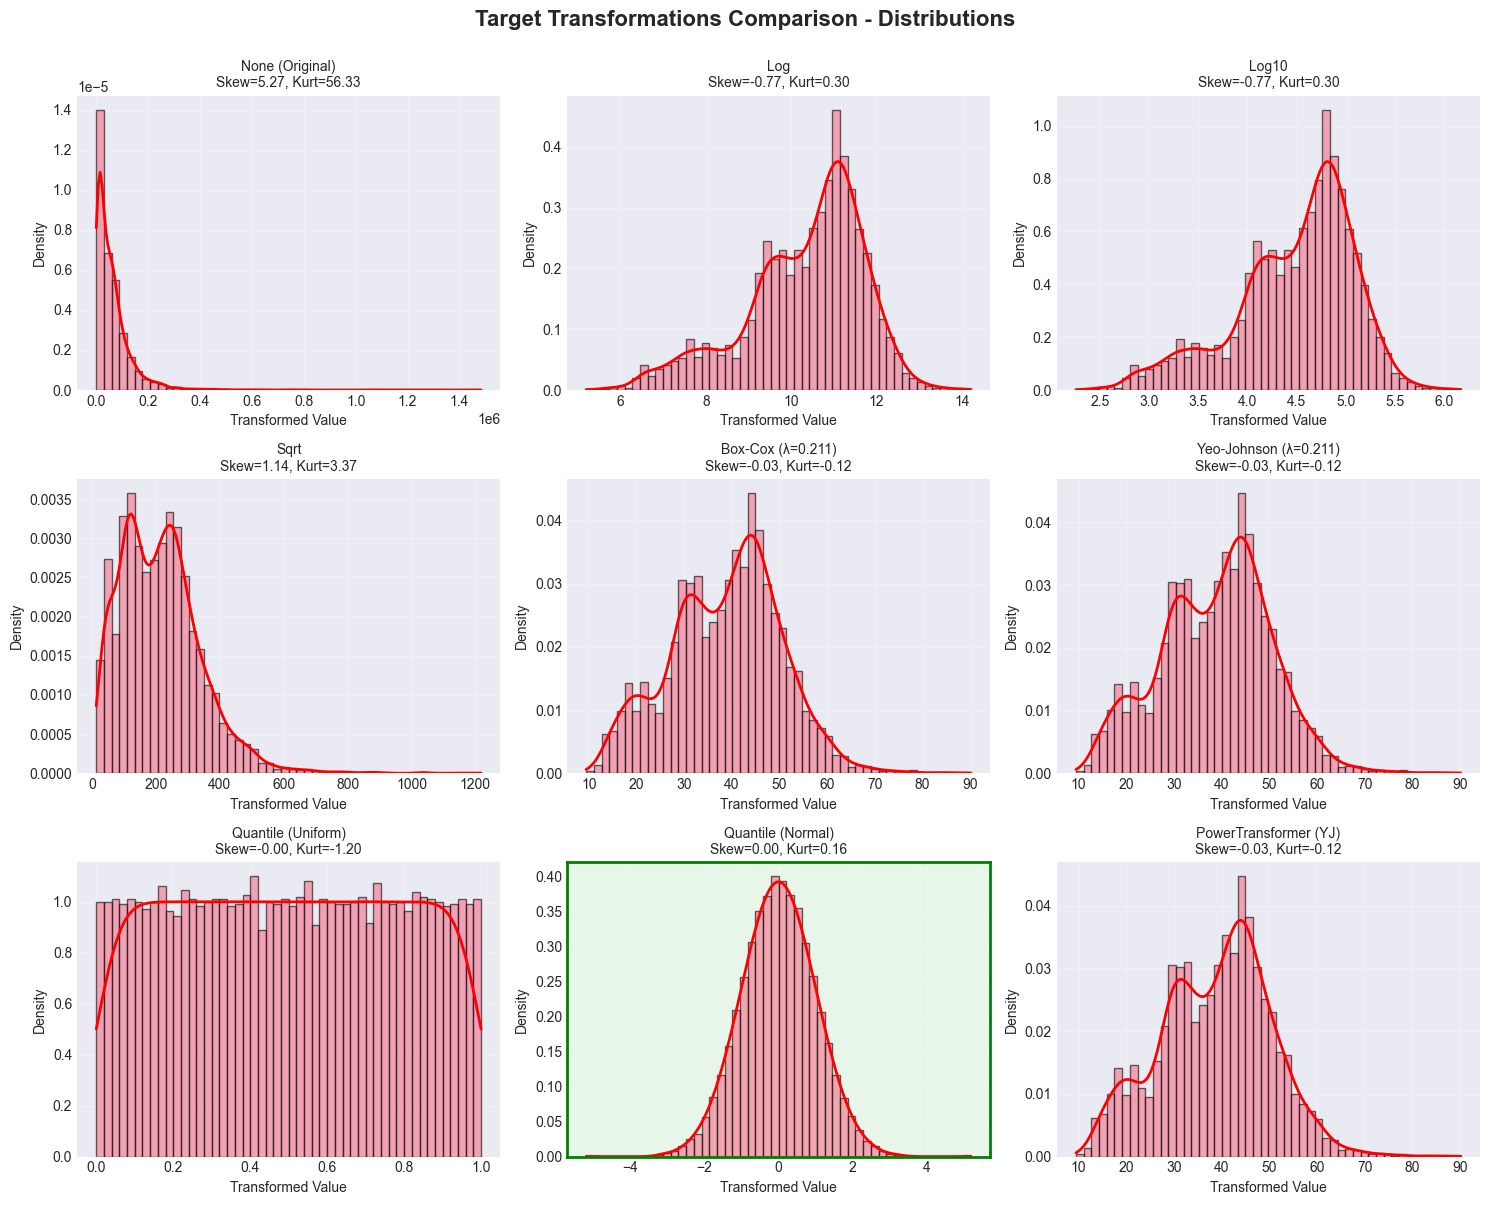

In [7]:
# Grid di plot: histogram + KDE per ogni trasformazione
n_transforms = len(transformations)
n_cols = 3
n_rows = (n_transforms + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten() if n_transforms > 1 else [axes]

for idx, (name, y_transformed) in enumerate(transformations.items()):
    ax = axes[idx]
    
    # Histogram + KDE
    ax.hist(y_transformed, bins=50, density=True, alpha=0.6, edgecolor='black')
    
    # KDE
    try:
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(y_transformed)
        x_range = np.linspace(y_transformed.min(), y_transformed.max(), 200)
        ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
    except:
        pass
    
    # Statistiche nel titolo
    skew = stats.skew(y_transformed)
    kurt = stats.kurtosis(y_transformed)
    
    ax.set_title(f"{name}\nSkew={skew:.2f}, Kurt={kurt:.2f}", fontsize=10)
    ax.set_xlabel('Transformed Value')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)
    
    # Highlight best
    if name == best['Transformation']:
        ax.set_facecolor('#e8f5e9')
        for spine in ax.spines.values():
            spine.set_edgecolor('green')
            spine.set_linewidth(2)

# Rimuovi assi extra
for idx in range(n_transforms, len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Target Transformations Comparison - Distributions', 
             fontsize=16, fontweight='bold', y=1.00)

save_plot("02_distributions_grid")
plt.show()

## 📊 5. Q-Q Plots Grid

💾 Salvato: 03_qq_plots_grid.png


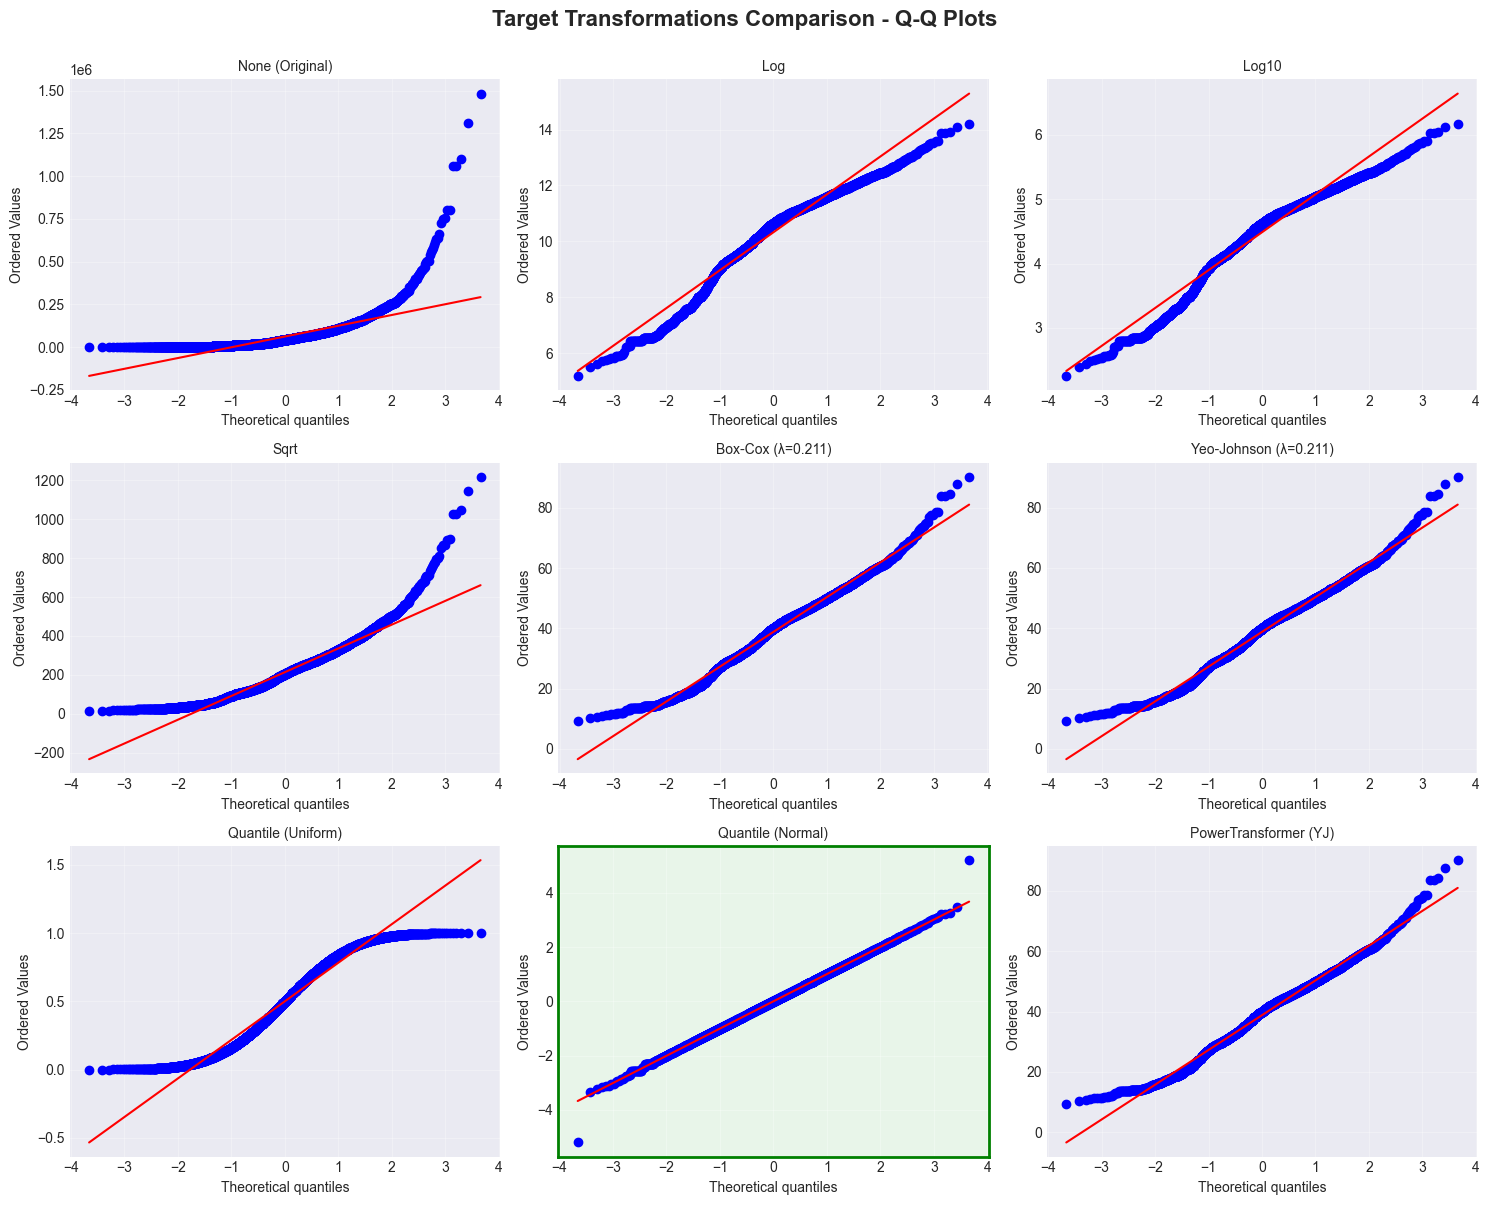

In [8]:
# Grid di Q-Q plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten() if n_transforms > 1 else [axes]

for idx, (name, y_transformed) in enumerate(transformations.items()):
    ax = axes[idx]
    
    # Q-Q plot
    stats.probplot(y_transformed, dist="norm", plot=ax)
    ax.set_title(f"{name}", fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Highlight best
    if name == best['Transformation']:
        ax.set_facecolor('#e8f5e9')
        for spine in ax.spines.values():
            spine.set_edgecolor('green')
            spine.set_linewidth(2)

# Rimuovi assi extra
for idx in range(n_transforms, len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Target Transformations Comparison - Q-Q Plots', 
             fontsize=16, fontweight='bold', y=1.00)

save_plot("03_qq_plots_grid")
plt.show()

## 📊 6. Comparison Bar Charts

💾 Salvato: 04_metrics_comparison.png


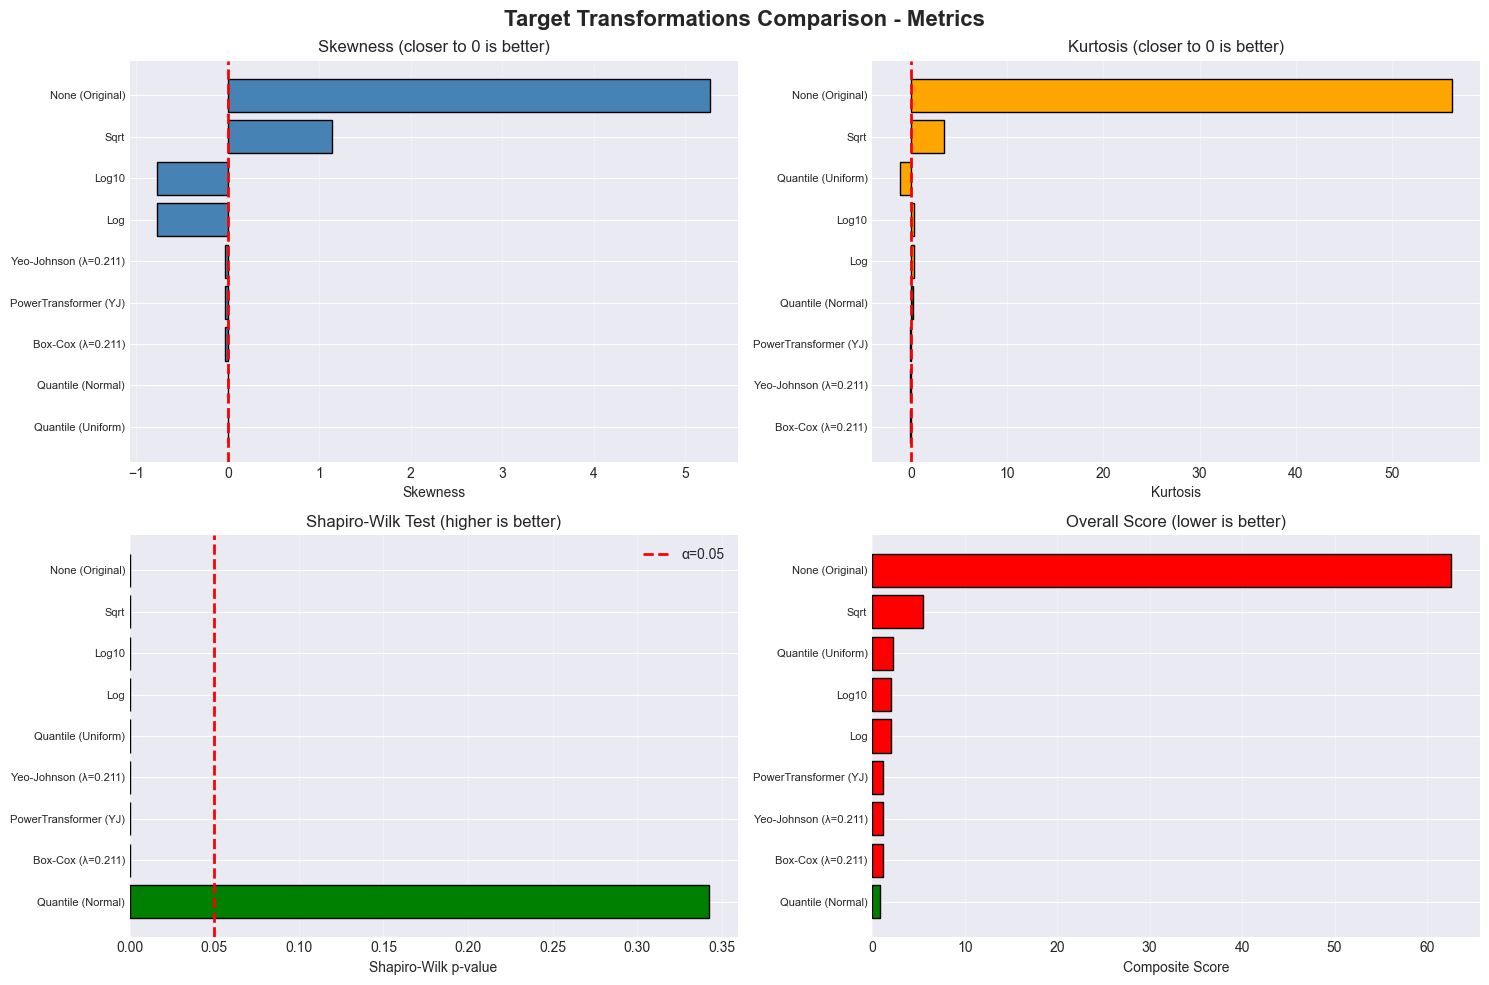

In [9]:
# Bar charts per metriche chiave
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Skewness
results_df_sorted = results_df.sort_values('Skewness', key=abs)
colors = ['green' if x == best['Transformation'] else 'steelblue' for x in results_df_sorted['Transformation']]
axes[0, 0].barh(range(len(results_df_sorted)), results_df_sorted['Skewness'], color=colors, edgecolor='black')
axes[0, 0].set_yticks(range(len(results_df_sorted)))
axes[0, 0].set_yticklabels(results_df_sorted['Transformation'], fontsize=8)
axes[0, 0].set_xlabel('Skewness')
axes[0, 0].set_title('Skewness (closer to 0 is better)')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Kurtosis
results_df_sorted = results_df.sort_values('Kurtosis', key=abs)
colors = ['green' if x == best['Transformation'] else 'orange' for x in results_df_sorted['Transformation']]
axes[0, 1].barh(range(len(results_df_sorted)), results_df_sorted['Kurtosis'], color=colors, edgecolor='black')
axes[0, 1].set_yticks(range(len(results_df_sorted)))
axes[0, 1].set_yticklabels(results_df_sorted['Transformation'], fontsize=8)
axes[0, 1].set_xlabel('Kurtosis')
axes[0, 1].set_title('Kurtosis (closer to 0 is better)')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Shapiro p-value
results_df_sorted = results_df.sort_values('Shapiro_p', ascending=False)
colors = ['green' if x == best['Transformation'] else 'purple' for x in results_df_sorted['Transformation']]
axes[1, 0].barh(range(len(results_df_sorted)), results_df_sorted['Shapiro_p'], color=colors, edgecolor='black')
axes[1, 0].set_yticks(range(len(results_df_sorted)))
axes[1, 0].set_yticklabels(results_df_sorted['Transformation'], fontsize=8)
axes[1, 0].set_xlabel('Shapiro-Wilk p-value')
axes[1, 0].set_title('Shapiro-Wilk Test (higher is better)')
axes[1, 0].axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='α=0.05')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Composite Score
results_df_sorted = results_df.sort_values('Score')
colors = ['green' if x == best['Transformation'] else 'red' for x in results_df_sorted['Transformation']]
axes[1, 1].barh(range(len(results_df_sorted)), results_df_sorted['Score'], color=colors, edgecolor='black')
axes[1, 1].set_yticks(range(len(results_df_sorted)))
axes[1, 1].set_yticklabels(results_df_sorted['Transformation'], fontsize=8)
axes[1, 1].set_xlabel('Composite Score')
axes[1, 1].set_title('Overall Score (lower is better)')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.suptitle('Target Transformations Comparison - Metrics', 
             fontsize=16, fontweight='bold')

save_plot("04_metrics_comparison")
plt.show()

## 📋 7. Summary Report

In [10]:
# Report finale
report = {
    'dataset': {
        'n_samples': len(y),
        'original_mean': float(y.mean()),
        'original_median': float(np.median(y)),
        'original_std': float(y.std()),
        'original_skew': float(stats.skew(y)),
        'original_kurtosis': float(stats.kurtosis(y)),
    },
    'transformations_tested': len(transformations),
    'best_transformation': {
        'name': best['Transformation'],
        'skewness': float(best['Skewness']),
        'kurtosis': float(best['Kurtosis']),
        'shapiro_p': float(best['Shapiro_p']),
        'score': float(best['Score']),
    },
    'current_transformation': {
        'name': current['Transformation'] if current is not None else None,
        'skewness': float(current['Skewness']) if current is not None else None,
        'kurtosis': float(current['Kurtosis']) if current is not None else None,
        'shapiro_p': float(current['Shapiro_p']) if current is not None else None,
        'score': float(current['Score']) if current is not None else None,
    } if current is not None else None,
    'recommendation': (
        'Keep current transformation (Yeo-Johnson)' 
        if current is not None and best['Transformation'] == current['Transformation']
        else f"Consider switching to {best['Transformation']}"
    )
}

# Salva JSON
import json
with open(OUTPUT_DIR / "00_summary_report.json", 'w') as f:
    json.dump(report, f, indent=2)

print("=" * 80)
print("📋 FINAL REPORT")
print("=" * 80)
print(json.dumps(report, indent=2))
print(f"\n💾 Salvato: 00_summary_report.json")

📋 FINAL REPORT
{
  "dataset": {
    "n_samples": 5499,
    "original_mean": 61661.76969853556,
    "original_median": 41755.0,
    "original_std": 78921.39848847577,
    "original_skew": 5.270601727411288,
    "original_kurtosis": 56.32664716150341
  },
  "transformations_tested": 9,
  "best_transformation": {
    "name": "Quantile (Normal)",
    "skewness": 0.0009123024830105083,
    "kurtosis": 0.16011811202335258,
    "shapiro_p": 0.34215698560869484,
    "score": 0.8188734288976682
  },
  "current_transformation": {
    "name": "Yeo-Johnson (\u03bb=0.211)",
    "skewness": -0.03146456939864942,
    "kurtosis": -0.11528658351736532,
    "shapiro_p": 5.845514379377791e-17,
    "score": 1.1467511529160146
  },
  "recommendation": "Consider switching to Quantile (Normal)"
}

💾 Salvato: 00_summary_report.json


## ✅ Conclusioni

### File Generati

1. `00_summary_report.json` - Report completo
2. `01_transformations_comparison.csv` - Tabella comparativa
3. `02_distributions_grid.png` - Grid distribuzioni
4. `03_qq_plots_grid.png` - Grid Q-Q plots
5. `04_metrics_comparison.png` - Bar charts metriche

### Key Insights

- **Best transformation**: Quella con score più basso
- **Current (Yeo-Johnson)**: Performance attuale
- **Recommendation**: Mantieni o cambia?

### Note

- Quantile transformer ha spesso score migliore MA perde interpretabilità
- Box-Cox e Yeo-Johnson sono parametriche (lambda fitted)
- Per ML, normalità non è strettamente necessaria ma aiuta
- Yeo-Johnson gestisce valori negativi (Box-Cox no)